In [1]:
from attn_heatmaps import *

import sys
sys.path.insert(0, '..')

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.utils import io
import re

import pandas as pd

from allennlp.common.util import import_submodules
from allennlp.predictors import Predictor
from allennlp.data.tokenizers import WordTokenizer

import torch
import torch.nn as nn
from torch._tensor_str import set_printoptions 

set_printoptions(sci_mode=False)
import_submodules('jdnlp')

_tokenizer = WordTokenizer().tokenize

I1210 00:37:33.716948 140023640765824 file_utils.py:32] TensorFlow version 2.0.0 available.
I1210 00:37:33.718059 140023640765824 file_utils.py:39] PyTorch version 1.2.0 available.
I1210 00:37:33.736094 140023640765824 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I1210 00:37:33.804893 140023640765824 registrable.py:73] instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
I1210 00:37:33.806254 140023640765824 registrable.py:73] instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
I1210 00:37:33.807512 140023640765824 registrable.py:73] instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
I1210 00:37:33.809004 140023640765824 registrable.py:73] instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>


In [90]:
df = pd.read_json("../datasets/iac2/train.jsonl", lines=True).query("label == 'sarc'")
df['length'] = df.text.apply(lambda x: len(' '.join(x).split(' ')))

df = df.sort_values(by='length').reset_index(drop=True)
df.head(20)

,label,text,length
0,sarc,"[As do you., What, to be ""open-minded?"" or to ...",14
1,sarc,"[this is the omega word, And you're a poor rep...",15
2,sarc,"[Anyone not currently in prison., Including th...",16
3,sarc,[What's the difference between humans and chim...,17
4,sarc,"[Don't quit your day job., Oh damn it...and I ...",17
5,sarc,[Interesting. The Creationists are evading thi...,19
6,sarc,"[And what exactly is a ""God-fearing athiest"" a...",20
7,sarc,"[it's the other way around:, So you are saying...",20
8,sarc,"[Incredibly enough, ignoring my rebuttal doesn...",20
9,sarc,"[But genetics has nothing to do with it., So y...",20


In [3]:
def load_model():
    model = Predictor.from_path("../saved/remembert/sarc/model.tar.gz", predictor_name="text_classifier", cuda_device=0)
    mac = model._model

    read_unit = mac.mac.read
    ctrl_unit = mac.mac.control
    
    return model, mac, read_unit, ctrl_unit

# model, mac, read_unit, ctrl_unit = load_model()

In [20]:
# pal = sns.choose_light_palette(input='rgb')#, as_cmap=True)
pal = [
    np.array([0.98333333, 0.91666667, 0.91666667, 1.        ]),
     np.array([0.95300654, 0.86542484, 0.86542484, 1.        ]),
     np.array([0.92267974, 0.81418301, 0.81418301, 1.        ]),
     np.array([0.89235294, 0.76294118, 0.76294118, 1.        ]),
     np.array([0.86202614, 0.71169935, 0.71169935, 1.        ]),
     np.array([0.83169935, 0.66045752, 0.66045752, 1.        ]),
     np.array([0.80137255, 0.60921569, 0.60921569, 1.        ]),
     np.array([0.77104575, 0.55797386, 0.55797386, 1.        ]),
     np.array([0.74071895, 0.50673203, 0.50673203, 1.        ]),
     np.array([0.71039216, 0.4554902 , 0.4554902 , 1.        ]),
     np.array([0.68006536, 0.40424837, 0.40424837, 1.        ]),
     np.array([0.64973856, 0.35300654, 0.35300654, 1.        ]),
     np.array([0.61941176, 0.30176471, 0.30176471, 1.        ]),
     np.array([0.58908497, 0.25052288, 0.25052288, 1.        ]),
     np.array([0.55875817, 0.19928105, 0.19928105, 1.        ]),
     np.array([0.52843137, 0.14803922, 0.14803922, 1.        ]),
 np.array([0.5, 0.1, 0.1, 1. ])
]

pal = sns.light_palette("navy")

[array([0.98333333, 0.91666667, 0.91666667, 1.        ]), array([0.95300654, 0.86542484, 0.86542484, 1.        ]), array([0.92267974, 0.81418301, 0.81418301, 1.        ]), array([0.89235294, 0.76294118, 0.76294118, 1.        ]), array([0.86202614, 0.71169935, 0.71169935, 1.        ]), array([0.83169935, 0.66045752, 0.66045752, 1.        ]), array([0.80137255, 0.60921569, 0.60921569, 1.        ]), array([0.77104575, 0.55797386, 0.55797386, 1.        ]), array([0.74071895, 0.50673203, 0.50673203, 1.        ]), array([0.71039216, 0.4554902 , 0.4554902 , 1.        ]), array([0.68006536, 0.40424837, 0.40424837, 1.        ]), array([0.64973856, 0.35300654, 0.35300654, 1.        ]), array([0.61941176, 0.30176471, 0.30176471, 1.        ]), array([0.58908497, 0.25052288, 0.25052288, 1.        ]), array([0.55875817, 0.19928105, 0.19928105, 1.        ]), array([0.52843137, 0.14803922, 0.14803922, 1.        ]), array([0.5, 0.1, 0.1, 1. ])]


In [77]:
start = 25 # 150
for i,t in enumerate(df.text.values[start+1:start+26], start+1):
    print(i, '\n\n'.join(t))
    print('\n---\n')

26 http://www.bloomberg.com/apps/news?p...d=awia81URdshwWho the hell is he to say the love between my partner and I of 8 years is weak?! It's stronger than many heterosexual couples.

Well if you are Catholic you would should probably find him pretty credible.

---

27 creationism is a joke dependent on an unproven god. evolution literally happens. it's fact. get over it

wow, lets all clap for that great argument for evolutionism. personally, i'm not sure why this is being brought up again.

---

28 And you dare point out my shortcomings? Please. You betta proofread your posts before sending them to me, because I will call you on it.

Neat my very own living spell check I can't wait to see well it works.

---

29 I see you ARE shooting yourself in the foot. Ok. Your progatative.

The riddles continue? emoticonXConfused Wouldn't it have taken less time and have been less ambiguous if you or Dr Spock just posted the # of the post?emoticonXRolleyes emoticonXRolleyes

---

30 if they are 

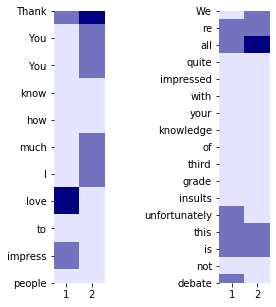

In [169]:
with io.capture_output() as captured:
    import_submodules('jdnlp')
    model, mac, read_unit, ctrl_unit = load_model()

i = 82 # 82, 150, 173 # train
# i = # 43 # test
txt = list(map(lambda x: re.sub(r'[\"\/\',.?!]', ' ', x), df.text[i]))

model.predict_batch_json([{"sentence": txt}, {"sentence": txt}])
parent, comment = map(_tokenizer, txt)

# step size x words
ctrl_attn = unwrap_tensor(torch.stack(ctrl_unit.saved_attn, axis=0)[:, 0, :len(comment)].squeeze(-1))
read_attn = unwrap_tensor(torch.stack(read_unit.saved_attn, axis=0)[:, 0, :len(parent)].squeeze(-1))

fig, axes = plt.subplots(ncols=2, figsize=(5,5)) # 3,15
fig.subplots_adjust(left=0.3, wspace=2.25)

pal = sns.light_palette("navy", n_colors=3)

hm_c = sns.heatmap(ctrl_attn.T, cmap=pal, cbar=False, ax=axes[0]) 
hm_c.set_yticklabels(comment, rotation=(360))
hm_c.set_xticklabels([1,2])
# hm_c.set_title('Comment')

hm_r = sns.heatmap(read_attn.T, cmap=pal, cbar=False, ax=axes[1])
hm_r.set_yticklabels(parent, rotation=(360))
hm_r.set_xticklabels([1,2])
# hm_r.set_title('Reply')

plt.savefig('acl2020_attn.pdf', bbox_inches = "tight")
plt.show()

In [118]:
pal[:-3]

[array([0.9, 0.9, 1. , 1. ]),
 array([0.81882353, 0.81882353, 0.95507882, 1.        ]),
 array([0.73764706, 0.73764706, 0.91015763, 1.        ]),
 array([0.65647059, 0.65647059, 0.86523645, 1.        ]),
 array([0.57176471, 0.57176471, 0.81836217, 1.        ]),
 array([0.49058824, 0.49058824, 0.77344098, 1.        ]),
 array([0.40941176, 0.40941176, 0.7285198 , 1.        ]),
 array([0.32823529, 0.32823529, 0.68359862, 1.        ]),
 array([0.24352941, 0.24352941, 0.63672434, 1.        ])]

In [94]:
txt

['We re all quite impressed with your knowledge of third grade insults  unfortunately  this is not debate ',
 'Thank You  You know how much I love to impress people ']

In [45]:
read_attn[0].sum()

1.0

In [51]:
mac.saved_inp

{'tokens': tensor([[[  83,  200,  475,  154,   37, 1977,    9,  823,   37, 4930,    9,
            668,   11,  312,   73, 5718,   11,  510],
          [  38,   30,    8,   17,   16, 3631,   73,    8,  197,   22,  510,
              0,    0,    0,    0,    0,    0,    0]],
 
         [[  83,  200,  475,  154,   37, 1977,    9,  823,   37, 4930,    9,
            668,   11,  312,   73, 5718,   11,  510],
          [  38,   30,    8,   17,   16, 3631,   73,    8,  197,   22,  510,
              0,    0,    0,    0,    0,    0,    0]]], device='cuda:0')}

In [9]:
import entmax
import torch

In [22]:
entmax.entmax15(torch.randn(20))

tensor([0.0000, 0.0991, 0.1548, 0.0000, 0.1845, 0.0537, 0.0083, 0.0000, 0.0000,
        0.3966, 0.0000, 0.0000, 0.0000, 0.0462, 0.0000, 0.0495, 0.0000, 0.0068,
        0.0000, 0.0004])

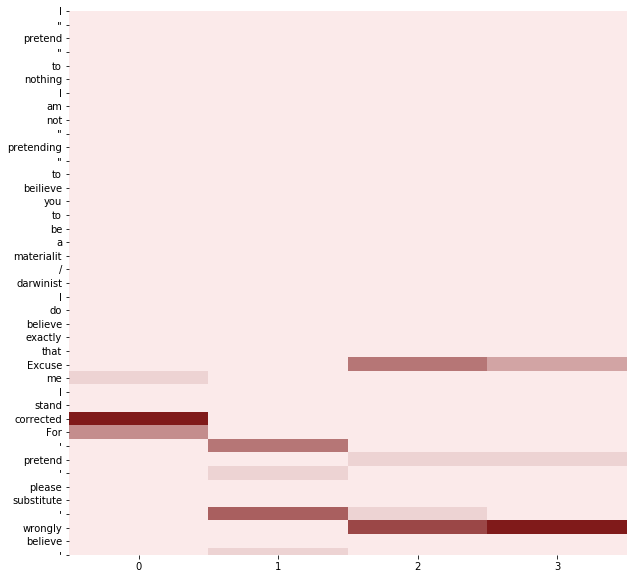

In [56]:
fig, ax = plt.subplots(figsize=(10,10))

ctrl_attn = np.array(unwrap_tensor(torch.stack(ctrl_unit.saved_attn, axis=0)[:, 0, :len(comment)].squeeze()))
read_attn = np.array(unwrap_tensor(torch.stack(read_unit.saved_attn, axis=0)[:, 0, :len(parent)]))
w = rescale(np.concatenate([read_attn, ctrl_attn], axis=1)).T

# pal = sns.color_palette("coolwarm", 15)# sns.light_palette("navy")

hm = sns.heatmap(w, cmap=pal, cbar=False)
hm.set_yticklabels(parent + comment, rotation=(360))
plt.show()

In [85]:
matprint(read_attn)

0.0588438  0.0914803  0.0729389  0.0436123  0.0563162  0.0304176  0.0588469  0.0711222  0.0634906  0.0197943  0.0644928   0.0139861  0.0554547  0.0342743  0.0214202  0.0662683  0.0565491  0.0073832     0.0259  0.0874079  
0.0514709  0.0910281  0.0738069  0.0325994   0.054199  0.0265454  0.0658912  0.0721207  0.0704513  0.0153179  0.0623263  0.00347087  0.0567221  0.0469491   0.022593  0.0756779  0.0744722          0  0.0189663  0.0853915  
0.0533743  0.0848151  0.0756481  0.0362991   0.061525  0.0276153  0.0613521  0.0774768  0.0661729  0.0181424  0.0606014   0.0105308   0.052683  0.0422414  0.0279822  0.0738529  0.0665794          0  0.0238426   0.079265  
0.0542284  0.0838495  0.0753005  0.0402832  0.0611968  0.0269509  0.0598526  0.0785502  0.0655081  0.0232971  0.0609443   0.0113894  0.0490842  0.0401328  0.0297968  0.0717535  0.0643568          0  0.0218706  0.0816542  


In [111]:
len(texts), len(w[:, 0])

(65, 65)

In [108]:
w.shape

(65, 4)

In [120]:
len(texts) < len(attns)

False

(37,)

In [125]:
texts = [list(map(str, parent)), list(map(str, comment))]
attns = [w[:len(parent), 0], w[:len(comment), 0]]
colors = ['blue', 'red']

generate(texts, attns, "sample.tex", colors, rescale_value=True)
!cat sample.tex

\documentclass[varwidth]{standalone}
    \special{papersize=210mm,297mm}
    \usepackage{color}
    \usepackage{tcolorbox}
    \usepackage{CJK}
    \usepackage{adjustbox}
    \tcbset{width=0.9\textwidth,boxrule=0pt,colback=red,arc=0pt,auto outer arc,left=0pt,right=0pt,boxsep=5pt}
    \begin{document}
\begin{CJK*}{UTF8}{gbsn}{\setlength{\fboxsep}{0pt}\colorbox{white!0}{\parbox{0.9\textwidth}{\colorbox{blue!79.69361}{\strut What} \colorbox{blue!8.501517}{\strut are} \colorbox{blue!69.084045}{\strut "} \colorbox{blue!13.0092535}{\strut women} \colorbox{blue!86.46831}{\strut 's} \colorbox{blue!21.351526}{\strut rights} \colorbox{blue!54.870766}{\strut "} \colorbox{blue!80.875015}{\strut ?} \colorbox{blue!19.707031}{\strut They} \colorbox{blue!0.0}{\strut special} \colorbox{blue!0.0}{\strut too} \colorbox{blue!35.792297}{\strut ?} \colorbox{blue!5.3356605}{\strut Now} \colorbox{blue!100.0}{\strut think} \colorbox{blue!66.8674}{\strut "} \colorbox{blue!23.015064}{\strut women} \colorbox{blue

In [ ]:
%%script false

from allennlp.nn import util
util.masked_softmax(self_attentive_logits, mask_tokens)
util.weighted_sum(encoded_tokens, self_weights)

In [9]:
0/0

ZeroDivisionError: division by zero

In [ ]:
xs = [{"sentence": t} for t in df.text.values[:16]]
preds = model.predict_batch_json(xs)# [{"sentence": x}, {"sentence": x}])

#predict(x)

In [ ]:
from entmax import sparsemax

In [ ]:
read_unit.saved_attn[0][3].std()

In [ ]:
[a.std() for a in ctrl_unit.saved_attn[0]]

In [ ]:
import torch
torch.cat(read_unit.saved_attn).shape

In [ ]:
len(ctrl_attns.saved_attn[0])

In [ ]:
# read_unit.saved_attn[0][0]

import itertools

ctrl_attns = list(itertools.chain(*ctrl_unit.saved_attn))#.std()
type(ctrl_attns)